## **Proyek Akhir: Klasifikasi gambar**
Pengembangan Machine learning

# Data diri

> **Nama : Muhammad Faqih Hakim**

> **Alamat : Kabupaten Tangerang**

> **Email: mhmdfkih21@gmail.com:**

> **Nomor Telpon: +6281292126827**

# **kriteria**
- **Bebas Memilih Dataset yang Ingin Dipakai, tetapi Harus Memiliki Minimal 1000 Gambar**
- **Tidak Diperbolehkan Menggunakan Dataset Rock, Paper, Scissor**
- **Dataset Dibagi Menjadi 80% Train Set dan 20% Test Set**
- **Model Harus Menggunakan Model Sequential, Conv2D, Pooling Layer**
- **Akurasi pada Training dan Validation Set Minimal Sebesar 85%**
- **Membuat Plot Terhadap Akurasi dan Loss Model**
- **Menyimpan Model ke Dalam Format Saved Model, TF-Lite dan TFJS**

# **Saran**


-  **Mengimplementasikan Callback**
- Gambar-gambar pada dataset memiliki resolusi yang tidak seragam.
- **Dataset yang digunakan berisi lebih dari 10000 gambar.**
- Akurasi pada training set dan validation set minimal 95%.
- **Memiliki 3 buah kelas atau lebih.**
- Melakukan inference menggunakan salah satu model (TF-Lite, TFJS atau savedmodel dengan tf serving).




## **Import Dataset**

In [1]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
import glob
from google.colab import files
import shutil
import numpy as np
from PIL import Image
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

## **Load Dataset**

**Download dataset**

Tidak Diperbolehkan Menggunakan Dataset Rock, Paper, Scissor



> Link Dataset: https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

In [2]:
!pip install kaggle

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
License(s): copyright-authors
 94% 44.0M/47.0M [00:02<00:00, 15.9MB/s]
100% 47.0M/47.0M [00:02<00:00, 17.8MB/s]


**Ekstrak Dataset**

buat directory data untuk menyimpan

In [4]:
extract_dir = 'data/'
os.makedirs(extract_dir, exist_ok=True)

ekstrak dan simpan kedalam directory yang sudah dibuat sebelumnya

In [5]:
zip_file = 'shoe-vs-sandal-vs-boot-dataset-15k-images.zip'
data_zip = zipfile.ZipFile(zip_file, 'r')
data_zip.extractall(extract_dir)
data_zip.close()
extract_dir = 'data/Shoe vs Sandal vs Boot Dataset'
print(f"File ZIP '{zip_file}' telah diekstrak ke dalam direktori '{extract_dir}'")

File ZIP 'shoe-vs-sandal-vs-boot-dataset-15k-images.zip' telah diekstrak ke dalam direktori 'data/Shoe vs Sandal vs Boot Dataset'


"**Bebas Memilih Dataset yang Ingin Dipakai, tetapi Harus Memiliki Minimal 1000 Gambar**"



saran: Dataset yang digunakan berisi lebih dari 10000 gambar.

In [6]:
def count_images(root_dir):
    image_counts = defaultdict(int)
    for root, dirs, files in os.walk(root_dir):
        data = [f for f in files if f.endswith('.jpg')]
        if data:
            category = os.path.basename(root)
            image_counts[category] += len(data)
    return image_counts

image_counts = count_images(extract_dir)

for category, count in image_counts.items():
    print(f"Jumlah gambar '{category}': {count}")

total_images = sum(image_counts.values())
print(f"Total jumlah gambar keseluruhan: {total_images}")

Jumlah gambar 'Sandal': 5000
Jumlah gambar 'Shoe': 5000
Jumlah gambar 'Boot': 5000
Total jumlah gambar keseluruhan: 15000


## **Data Preparation**


**plot distribusi antar kelas**

disini terlihat bahwa data terdistribusi dengan sangat baik

Memiliki 3 buah kelas atau lebih.

<ipython-input-7-853bb83cc71d>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot_data.set_xticklabels(plot_data.get_xticklabels(), rotation=45)


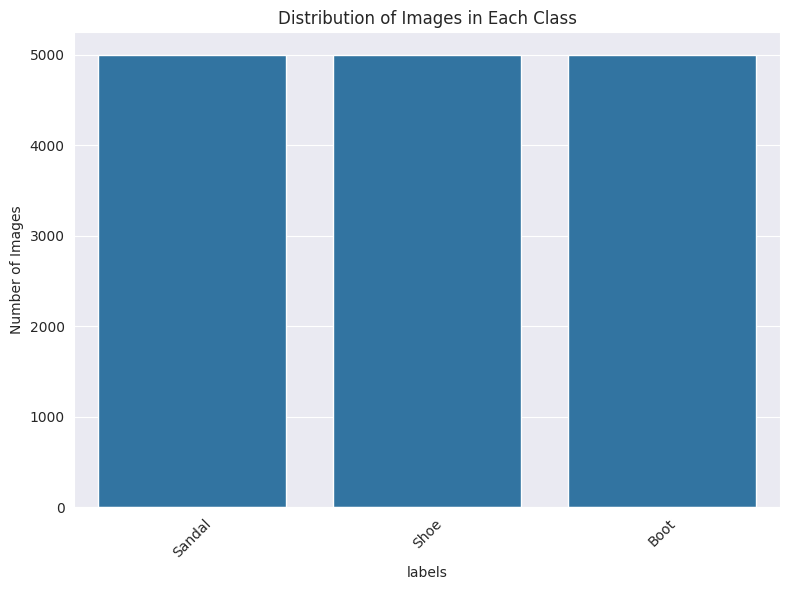

In [7]:
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(extract_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x='labels', data=distribution_train)
plot_data.set_title('Distribution of Images in Each Class')
plot_data.set_xticklabels(plot_data.get_xticklabels(), rotation=45)
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

Dataset Checking

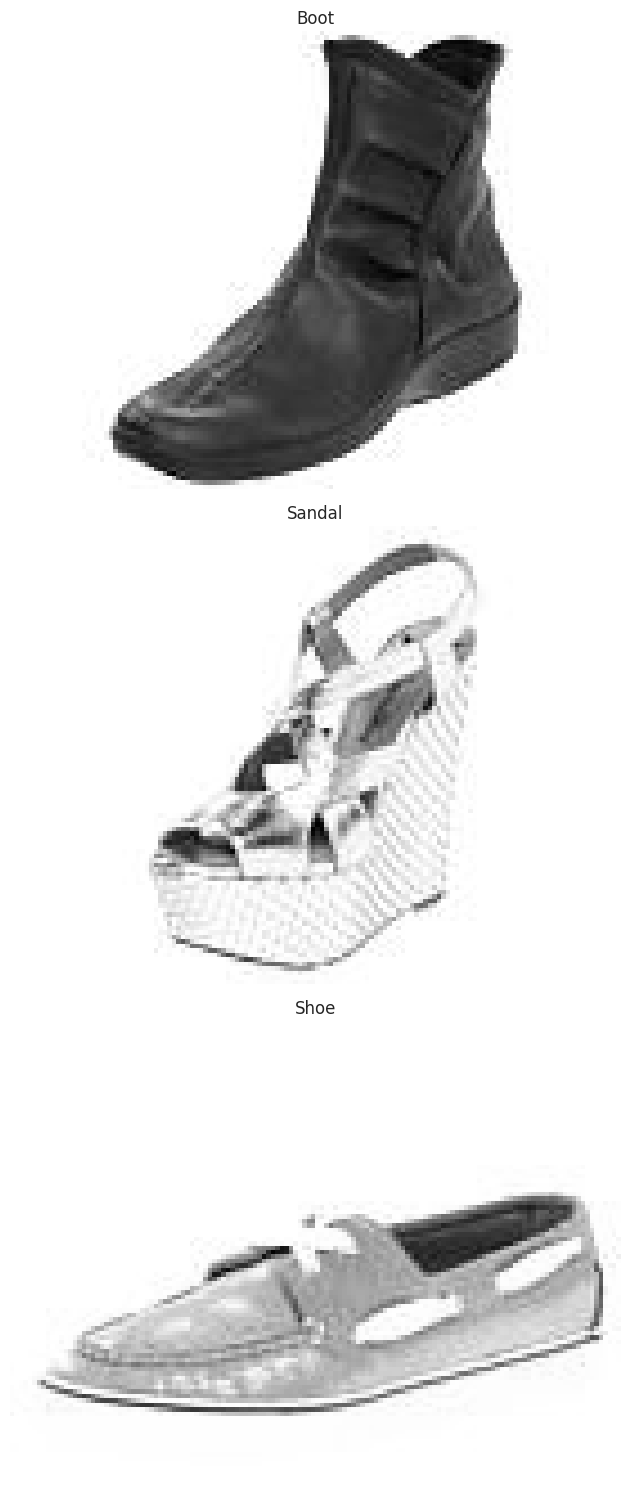

In [8]:
categories = {
    'Boot': 'Boot',
    'Sandal': 'Sandal',
    'Shoe': 'Shoe'
}

fig, axs = plt.subplots(len(categories), 1, figsize=(15, 15))

for i, (class_name, subdir_name) in enumerate(categories.items()):
    class_path = os.path.join(extract_dir, subdir_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
    if image_files:
        image_file = image_files[0]
        img_path = os.path.join(class_path, image_file)
        img = Image.open(img_path).convert("L")
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(class_name)
        axs[i].axis('off')

fig.tight_layout()
plt.show()

In [9]:
img_path = os.path.join(extract_dir, class_name, image_file)

**Split dataset**

simpan data menjadi sebuah dataFrame

In [10]:
df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})
df

,path,file_name,labels
0,data/Shoe vs Sandal vs Boot Dataset/Sandal/San...,Sandal (3742).jpg,Sandal
1,data/Shoe vs Sandal vs Boot Dataset/Sandal/San...,Sandal (3798).jpg,Sandal
2,data/Shoe vs Sandal vs Boot Dataset/Sandal/San...,Sandal (2222).jpg,Sandal
3,data/Shoe vs Sandal vs Boot Dataset/Sandal/San...,Sandal (1576).jpg,Sandal
4,data/Shoe vs Sandal vs Boot Dataset/Sandal/San...,Sandal (947).jpg,Sandal
...,...,...,...
14995,data/Shoe vs Sandal vs Boot Dataset/Boot/boot ...,boot (4302).jpg,Boot
14996,data/Shoe vs Sandal vs Boot Dataset/Boot/boot ...,boot (2692).jpg,Boot
14997,data/Shoe vs Sandal vs Boot Dataset/Boot/boot ...,boot (3213).jpg,Boot
14998,data/Shoe vs Sandal vs Boot Dataset/Boot/boot ...,boot (3170).jpg,Boot


Memisahkan label dan membagi dataset menjadi train dan test




> **Dataset Dibagi Menjadi 80% Train Set dan 20% Test Set**



In [11]:
for category in categories:
    class_path = os.path.join(extract_dir, category)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        train_dir = os.path.join('data_augmented', 'train', category)
        test_dir = os.path.join('data_augmented', 'test', category)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

        for img in train_images:
            shutil.copy2(os.path.join(class_path, img), os.path.join(train_dir, img))

        for img in test_images:
            shutil.copy2(os.path.join(class_path, img), os.path.join(test_dir, img))

mendefinisikan directory train dan test

In [12]:
train_dir = 'data_augmented/train'
test_dir = 'data_augmented/test'

## **Augmentasi data**

menormalisasikan data

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(136, 102),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(136, 102),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(136, 102),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 9600 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


## **Membangun model yang  Menggunakan Model Sequential, Conv2D, Pooling Layer**

In [14]:
model = tf.keras.models.Sequential([
     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(136, 102, 3)),
     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
     tf.keras.layers.Dropout(0.25),
     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
     tf.keras.layers.Dropout(0.25),

     tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
     tf.keras.layers.Dropout(0.25),

     tf.keras.layers.GlobalAveragePooling2D(),

     tf.keras.layers.Dense(512, activation='relu'),
     tf.keras.layers.Dropout(0.5),

     tf.keras.layers.Dense(256, activation='relu'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(3, activation='softmax')
])

Cek arsitektur model

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 134, 100, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 67, 50, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 67, 50, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 48, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 24, 128)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32, 24, 128)       0

Compaile model yang sudah dibuat

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# **Mengimplementasikan Callback**

Buat fungsi callback yang memanggil model saat sendang dilatih ketika akurasi sudah sesuai yang diinginkan

In [17]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') >= 0.92 and logs.get('accuracy') >= 0.92):
            print("\nPelatihan harus dihentikan karena Sudah mencapai target yang diinginkan")
            self.model.stop_training = True

callbacks = myCallback()

mendefinisikan variabel untuk mengatur epoch dan lain lain

In [18]:
Epoch_count = 30
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

Latih Model

In [19]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=Epoch_count,
    callbacks=[callbacks, reduce_lr]
)

Epoch 1/30
300/300 [==============================] - 72s 191ms/step - loss: 1.0070 - accuracy: 0.4733 - val_loss: 0.9211 - val_accuracy: 0.5725 - lr: 0.0010
Epoch 2/30
300/300 [==============================] - 61s 202ms/step - loss: 0.8227 - accuracy: 0.6016 - val_loss: 0.6789 - val_accuracy: 0.7050 - lr: 0.0010
Epoch 3/30
300/300 [==============================] - 57s 189ms/step - loss: 0.6509 - accuracy: 0.7089 - val_loss: 0.5361 - val_accuracy: 0.7671 - lr: 0.0010
Epoch 4/30
300/300 [==============================] - 64s 213ms/step - loss: 0.5495 - accuracy: 0.7700 - val_loss: 0.4838 - val_accuracy: 0.7958 - lr: 0.0010
Epoch 5/30
300/300 [==============================] - 79s 263ms/step - loss: 0.4885 - accuracy: 0.7953 - val_loss: 0.4491 - val_accuracy: 0.8196 - lr: 0.0010
Epoch 6/30
300/300 [==============================] - 57s 190ms/step - loss: 0.4493 - accuracy: 0.8218 - val_loss: 0.3712 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 7/30
300/300 [==============================] 

## **Plot Akurasi Model**

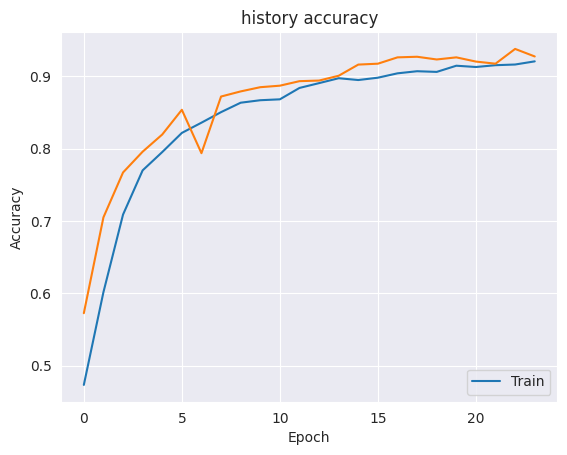

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('history accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

## **Plot Loss Model**

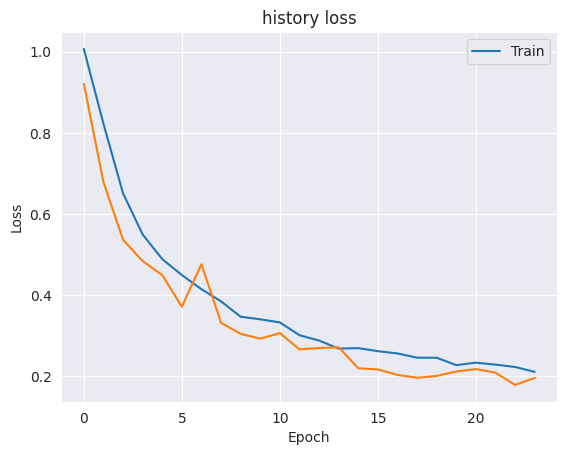

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('history loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

## Menyimpan model ke dalam savedModel, TF-lite, TFJS
---



In [22]:
import tensorflow as tf
save_path = 'mymodel/'
tf.saved_model.save(model, save_path)

## Convert SavedModel menjadi vegs.tflite



In [25]:
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('shoes.tflite')
tflite_model_file.write_bytes(tflite_model)


2542540

## Save model to TensorflowJs Untuk Dijalankan di Web

In [26]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


install Tensorflof Js

In [27]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 96.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 39.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
    

Konversi model ke tfjs

In [28]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2024-07-08 14:48:17.396321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 14:48:17.510800: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 14:48:17.510873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 14:48:19.195791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Terakhir download MyModel yang sudah disimpan sebelumnya dengan cara kita kompres terlebih dahulu

save model

In [30]:
zip_filename = 'mymodel.zip'
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(save_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), save_path))

TFJS-model

In [31]:
zip_filename = 'tfjs_model.zip'
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk('tfjs_model'):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), 'tfjs_model'))